<a href="https://colab.research.google.com/github/jnelly79/Colorado_Solar_Installation_Adoption_Rates_DS/blob/master/predicting_data/predicting_adoption_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training, Testing and Predicting the Data With:


*   Linear Regression
*   Auto Regressive Integrated Moving Average

*   Long-Short Term Memory Recurrent Neural Network





In [ ]:
"""
Import all necessary libraries to prepare for preprocessing, training, testing 
and predicting the data.
"""
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib
import matplotlib.pyplot as plt  
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline
!pip install pmdarima
from pmdarima import auto_arima   
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras import backend
 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
# Load the integrated dataset.
df = pd.read_excel('/content/drive/My Drive/datasets/data_practicum/integration_1_CW.xlsx', sheet_name='pred7')

In [ ]:
# Display the dataframe head.
df.head()

,Years,Total_emissions_wforecast,Total_emissions_wforecast_aleviated_emissions,Solar_kWh_generation_residential,Solar_kWh_generation_residential_incentives,Total energy consumed by the residential sector,electric_cost,est_installed_cost_$/W,state_level_gdp,est_annual_installed_capacity,est_annual_install_cap_after_incentives,est_cumul_installed_capacity,est_cumul_installed_capacity_after_incentives,cumul_est_roofs,cumul_est_roofs_after_incentives,est_pct_chng,est_pct_chng_after_incentives,adoption_rates,adoption_rates_incentives
0,2010,7900000.0,7900000.0,49000000.0,49000000.0,352315000000000,32.35,7.34,2.551405e+11,18.65,18.65,18.65,18.65,3390.909091,3390.909091,0.000000,0.000000,0.000000,0.000000
1,2011,7900000.0,7900000.0,65000000.0,65000000.0,354262000000000,33.02,6.44,2.644316e+11,13.80,13.80,32.45,32.45,5900.000000,5900.000000,0.739946,0.739946,0.002509,0.002509
2,2012,7100000.0,7100000.0,88000000.0,88000000.0,334949000000000,33.58,4.55,2.735195e+11,17.70,17.70,50.15,50.15,9118.181818,9118.181818,0.545455,0.545455,0.003218,0.003218
3,2013,8200000.0,8200000.0,124000000.0,124000000.0,363368000000000,34.96,3.97,2.883052e+11,28.20,28.20,78.35,78.35,14245.454550,14245.454550,0.562313,0.562313,0.005127,0.005127
4,2014,8100000.0,8100000.0,177000000.0,177000000.0,353334000000000,35.70,3.49,3.065711e+11,41.80,41.80,120.15,120.15,21845.454550,21845.454550,0.533504,0.533504,0.007600,0.007600


# Starting With Adoption Rates


**Linear Regression**

In [ ]:
# Set the dataframe index to Years.
df = df.set_index(['Years'])

"""
Select only the Solar_kWh_generation_residential, and electric_cost as predictor
features and adoption_rates as the target feature. Split the dataset into an
80/20 split.
"""
X = df[['Solar_kWh_generation_residential','electric_cost']]
Y = df['adoption_rates']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0, shuffle=False)

In [ ]:
# Define linear regression and fit the training data.
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get the coefficients of the predictor features.
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

                                   Coefficient
Solar_kWh_generation_residential  2.845934e-11
electric_cost                     4.850685e-04


In [ ]:
# Predict the target feature with the predicting testing features.
y_pred = model.predict(X_test)

In [ ]:
# Display the actual vs the predicted.
df_linear = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
print(df_linear.head(10))

         Actual  Predicted
Years                     
2022   0.012698   0.015702
2023   0.013586   0.016925
2024   0.015624   0.018148
2025   0.019208   0.019371


In [ ]:
# Display the dataframe head.
df_linear.head()

,Actual,Predicted
Years,,
2022,0.012698,0.015702
2023,0.013586,0.016925
2024,0.015624,0.018148
2025,0.019208,0.019371


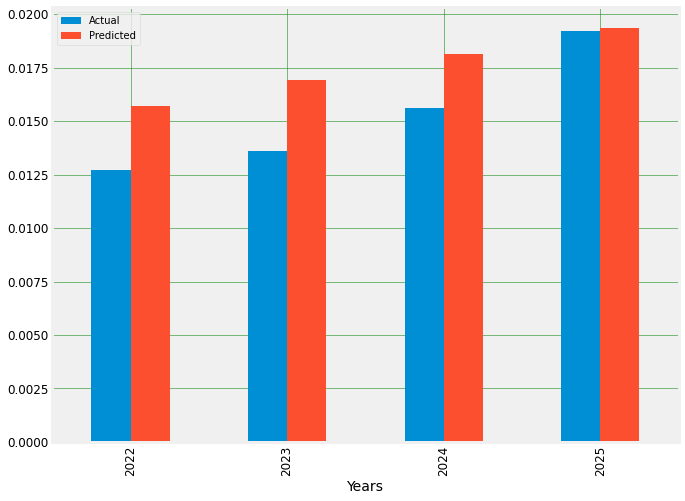

In [ ]:
# Plot a bar graph to visually display the actual vs the predicted.
df_linear.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

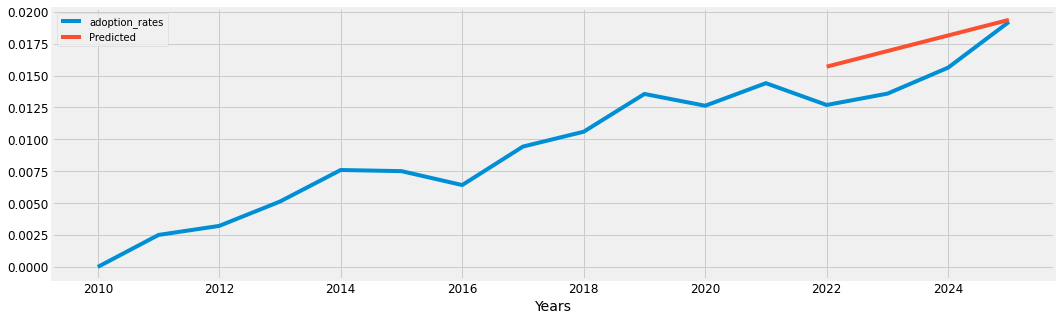

In [ ]:
# Plot a bar line to visually display the actual vs the predicted.
df['adoption_rates'].plot(figsize = (16,5), legend=True)
df_linear['Predicted'].plot(legend = True);

In [ ]:
# Get the model evaluation metrics and print them.
linear_mean_value = df['adoption_rates'].mean()     
linear_mse = mean_squared_error(Y_test, y_pred)
linear_rsme = np.sqrt(mean_squared_error(Y_test, y_pred))
linear_r2_value = r2_score(Y_test, y_pred)    
linear_mae = mean_absolute_error(Y_test, y_pred)


print('Mean Absolute Error:', linear_mae)  
print('Mean Squared Error:', linear_mse)  
print('Root Mean Squared Error:', linear_rsme)
print("Mean Value: ", linear_mean_value)
print("R^2 Value: ", linear_r2_value)

Mean Absolute Error: 0.0022575161351781987
Mean Squared Error: 6.642303952692676e-06
Root Mean Squared Error: 0.002577266760095407
Mean Value:  0.009634323404375
R^2 Value:  -0.0592412285646402


**Auto Regressive Integrated Moving Average**

In [ ]:
"""
Load the integrated dataset into a new dataframe with only just the years and
the target feature.
"""
lstm_for_df = pd.read_excel('/content/drive/My Drive/datasets/data_practicum/integration_1_CW.xlsx', sheet_name='pred7')
lstm_for_df = lstm_for_df[['Years','adoption_rates']]

In [ ]:
# Convert the Dtype Years to datetime.
lstm_for_df.Years = pd.to_datetime(lstm_for_df.Years,format='%Y')

In [ ]:
# Set the index to Years.
lstm_for_df = lstm_for_df.set_index("Years")
lstm_for_df.head()

,adoption_rates
Years,
2010-01-01,0.000000
2011-01-01,0.002509
2012-01-01,0.003218
2013-01-01,0.005127
2014-01-01,0.007600


In [ ]:
# Split the data into training and testing 80/20.
train_data = lstm_for_df[:len(lstm_for_df)-4]
test_data = lstm_for_df[len(lstm_for_df)-4:]

In [ ]:
# Define the ARIMA model with the dataframe and an ord of 0,1,1.
arima_mod = ARIMA(lstm_for_df,order=(0,1,1))

# Fit the data and display the summary.
arima_result = arima_mod.fit()
arima_result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.adoption_rates   No. Observations:                   15
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  76.894
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 22 Jun 2020   AIC                           -147.787
Time:                        01:25:54   BIC                           -145.663
Sample:                    01-01-2011   HQIC                          -147.810
                         - 01-01-2025                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0011   7.11e-05     15.247      0.000       0.001       0.001
ma.L1.D.adoption_rates    -0.9999      0.230     -4.340      0.000      -1.451      -0.548
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# Get the predicted results of the data and display the predictions.
arima_pred = arima_result.predict(start = len(train_data), end = len(lstm_for_df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-01-01    0.014795
2023-01-01    0.015717
2024-01-01    0.016648
2025-01-01    0.017663
Freq: AS-JAN, Name: ARIMA Predictions, dtype: float64

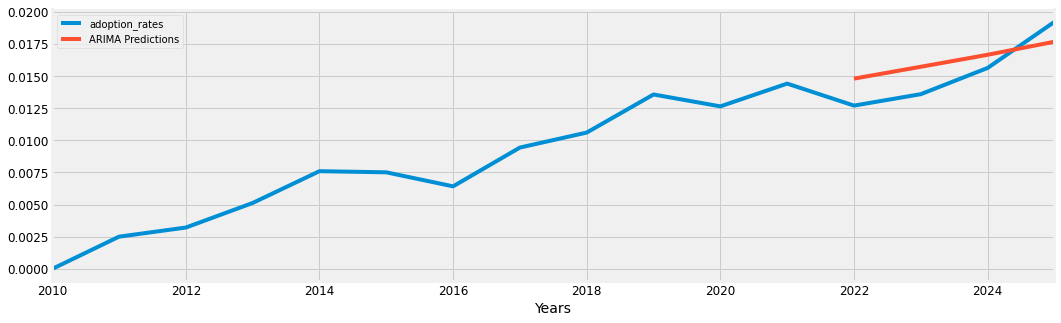

In [ ]:
# Plot the adotion rates and the predictions on a line graph. 
lstm_for_df['adoption_rates'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
# Get the evaluation metrics for the ARIMA model and print them.
arima_rmse_error = rmse(test_data['adoption_rates'], arima_pred)
arima_mse_error = arima_rmse_error**2
arima_mean_value = lstm_for_df['adoption_rates'].mean()
arima_r2_value = r2_score(test_data['adoption_rates'],arima_pred)
arima_mae = mean_absolute_error(test_data['adoption_rates'], arima_pred)

 
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {arima_mean_value}')
print('Mean absolute error: ',arima_mae)
print("R^2 Value: ", arima_r2_value)

MSE Error: 3.092111739895624e-06
RMSE Error: 0.0017584401439615805
Mean: 0.009634323404375
Mean absolute error:  0.0016988246861138093
R^2 Value:  0.5069041914442292


**Long-Short Term Memory Recurrent Neural Network**

In [ ]:
# Normalize and scale the data with MinMaxScaler transformer.
scaler = MinMaxScaler()
scaler.fit(lstm_for_df)
scaled_lstm_df = scaler.transform(lstm_for_df)

 
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
"""
Declare the number of inputs and features passing through the neural nework and
define the train/test generator with the TimeSeriesGenerator.
"""
n_input = 11
n_features= 1

train_generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=3, batch_size=1)

In [ ]:
"""
Create the model with 200 neurons, activation relu, an input shape of a 2d 
tensor with the n_input and the n_features. Add an output layer of 1, and then
compile with adam optimization algorithm, mean square error as the loss function,
and mean absolute error as the metrics.

Display the model summary.
"""
backend.clear_session()
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse',
             metrics = ['mae'])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Define a history of the model by fitting the neural network with the train
generator and training on 25 epochs, using the test generator as validation.
"""
history = lstm_model.fit_generator(train_generator,epochs=25, validation_data=test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
1/1 [==============================] - 0s 287ms/step - loss: 0.5136 - mae: 0.7167 - val_loss: 0.9106 - val_mae: 0.9543
Epoch 2/25
1/1 [==============================] - 0s 48ms/step - loss: 0.4706 - mae: 0.6860 - val_loss: 0.8785 - val_mae: 0.9373
Epoch 3/25
1/1 [==============================] - 0s 43ms/step - loss: 0.4292 - mae: 0.6551 - val_loss: 0.8469 - val_mae: 0.9203
Epoch 4/25
1/1 [==============================] - 0s 45ms/step - loss: 0.3893 - mae: 0.6239 - val_loss: 0.8158 - val_mae: 0.9032
Epoch 5/25
1/1 [==============================] - 0s 46ms/step - loss: 0.3501 - mae: 0.5917 - val_loss: 0.7852 - val_mae: 0.8861
Epoch 6/25
1/1 [==============================] - 0s 44ms/step - loss: 0.3109 - mae: 0.5576 - val_loss: 0.7549 - val_mae: 0.8689
Epoch 7/25
1/1 [==============================] - 0s 46ms/step - loss: 0.2721 - mae: 0.5216 - val_loss: 0.7248 - val_mae: 0.8514
Epoch 8/25
1/1 [====

In [ ]:
# Create a dictionary for the model history.
history_dict = history.history
loss_values = history_dict['loss']
acc_values = history_dict['mae']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)

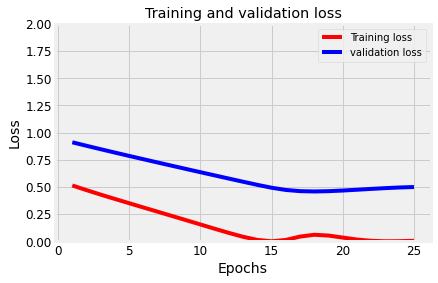

In [ ]:
# Plot the Training vs validation loss values.
plt.plot(epochs, loss_values, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.ylim(0,2)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Get a list of the predicted values.
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


In [ ]:
# Display the scaled predicted values.
lstm_predictions_scaled

[array([0.7335844], dtype=float32),
 array([0.7998149], dtype=float32),
 array([0.87272334], dtype=float32),
 array([0.9453298], dtype=float32)]

In [ ]:
# Inverse transform the scaled predicted values.
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
# Display the predicted values in normal format.
lstm_predictions

array([[0.01409055],
       [0.01536269],
       [0.01676311],
       [0.01815772]])

In [ ]:
# Add the predictions next to the actual values.
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
# Display the actual vs the lstm predictions.
test_data

,adoption_rates,LSTM_Predictions
Years,,
2022-01-01,0.012698,0.014091
2023-01-01,0.013586,0.015363
2024-01-01,0.015624,0.016763
2025-01-01,0.019208,0.018158


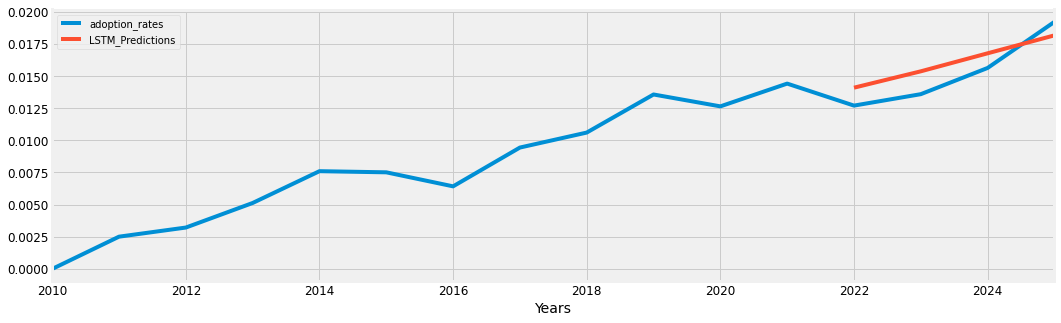

In [ ]:
# Plot on a line graph the actual and the predicted values.
lstm_for_df['adoption_rates'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
# Get the evaluation metrics for the model and print them.
lstm_rmse_error = rmse(test_data['adoption_rates'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
lstm_mean_value = lstm_for_df['adoption_rates'].mean()
lstm_r2_value = r2_score(test_data['adoption_rates'],test_data["LSTM_Predictions"])
lstm_mae = mean_absolute_error(test_data['adoption_rates'],test_data["LSTM_Predictions"])

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {lstm_mean_value}')
print('Mean absolute error: ', lstm_mae)
print("R^2 Value: ", lstm_r2_value)

MSE Error: 1.8736872707858614e-06
RMSE Error: 0.0013688269688992328
Mean: 0.009634323404375
Mean absolute error:  0.0013395018365797108
R^2 Value:  0.7012050606554092


In [ ]:
# Create a dataframe for all three adoption rate predictions.
df_results = pd.DataFrame(test_data)

In [ ]:
# Add the linear and the ARIMA predictions.
df_results['Linear_Predictions'] = df_linear['Predicted'].values
df_results['ARIMA_Predictions'] = arima_pred

In [ ]:
# Display all three results side by side.
df_results

,adoption_rates,LSTM_Predictions,Linear_Predictions,ARIMA_Predictions
Years,,,,
2022-01-01,0.012698,0.014091,0.015702,0.014795
2023-01-01,0.013586,0.015363,0.016925,0.015717
2024-01-01,0.015624,0.016763,0.018148,0.016648
2025-01-01,0.019208,0.018158,0.019371,0.017663


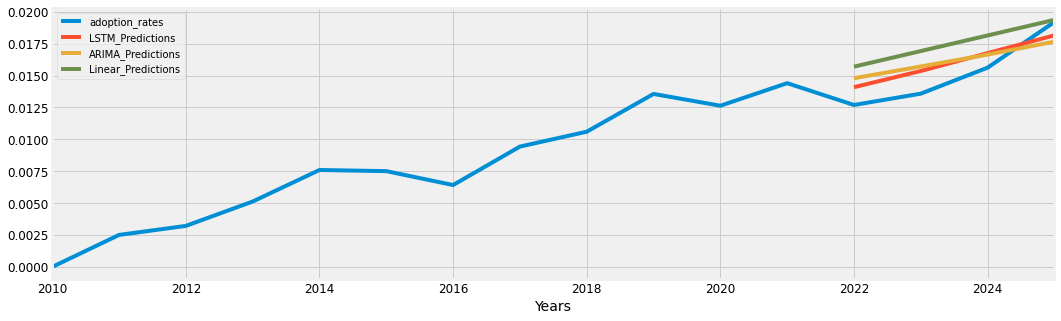

In [ ]:
# Plot on a line graph all three predictions with the actual values.
lstm_for_df['adoption_rates'].plot(figsize = (16,5), legend=True)
df_results['LSTM_Predictions'].plot(legend = True)
df_results['ARIMA_Predictions'].plot(legend = True)
df_results['Linear_Predictions'].plot(legend = True);

# Adoption Rates Incentives Predictions

**Linear Regression**

In [ ]:
# Reload the integrated dataset again.
dfi = pd.read_excel('/content/drive/My Drive/datasets/data_practicum/integration_1_CW.xlsx', sheet_name='pred7')

In [ ]:
"""
Set the index of the dataframe to Years and select the predictor features as 
solar_kWh_generation_residential_incentives, and electric_cost. Select the 
target feature as adoption_rates_incentives, then split the dataset into 
training/testing 80/20.
"""
dfi = dfi.set_index(['Years'])
Xi = dfi[['Solar_kWh_generation_residential_incentives', 'electric_cost']]
Yi = dfi['adoption_rates_incentives']
X_traini, X_testi, Y_traini, Y_testi = train_test_split(Xi, Yi, test_size=0.2, random_state= 0, shuffle=False)

In [ ]:
# Define the linear regression model and fit the training data.
model = linear_model.LinearRegression()
model.fit(X_traini, Y_traini)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get the coefficients for the predictor features.
coeff_dfi = pd.DataFrame(model.coef_, Xi.columns, columns=['Coefficient'])
print(coeff_dfi)

                                              Coefficient
Solar_kWh_generation_residential_incentives  2.626856e-11
electric_cost                                9.535807e-04


In [ ]:
# Predict the target test features based on the predcitor test features.
y_predi = model.predict(X_testi)

In [ ]:
# Display the actual vs the predictions.
df_lineari = pd.DataFrame({'Actual': Y_testi, 'Predicted': y_predi})
print(df_lineari.head(10))

         Actual  Predicted
Years                     
2022   0.021980   0.026249
2023   0.023518   0.029428
2024   0.027046   0.033053
2025   0.033249   0.037461


In [ ]:
# Create a dataframe of the actual and predicted.
df_lineari.head()

,Actual,Predicted
Years,,
2022,0.021980,0.026249
2023,0.023518,0.029428
2024,0.027046,0.033053
2025,0.033249,0.037461


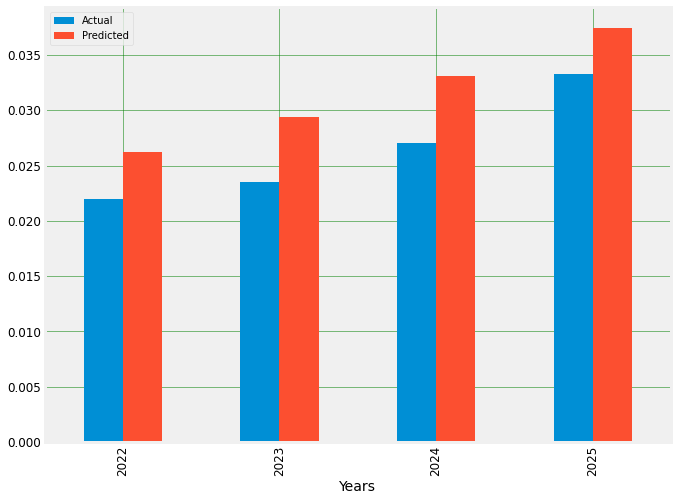

In [ ]:
# Plot on a bar graph the actual vs the predicted.
df_lineari.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

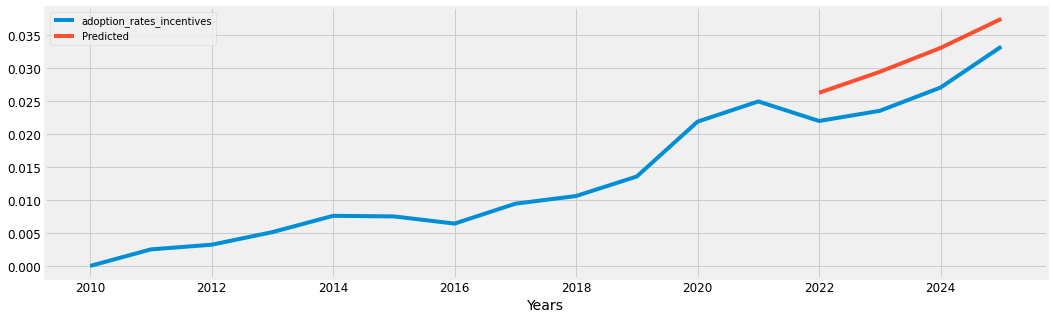

In [ ]:
# Plot on a line graph the actual and the predicted values.
dfi['adoption_rates_incentives'].plot(figsize = (16,5), legend=True)
df_lineari['Predicted'].plot(legend = True);

In [ ]:
# Get the model evaluation metrics and print them.
linear_rmsdi = np.sqrt(mean_squared_error(Y_testi, y_predi))
linear_mse_errori = linear_rmsdi**2
linear_mean_valuei = dfi['adoption_rates_incentives'].mean()     
linear_r2_valuei = r2_score(Y_testi, y_predi)
linear_maei = mean_absolute_error(Y_testi, y_predi)
                     


#print("Intercept: ", model.intercept_)
print("MSE: ", linear_mse_errori)
print("Root Mean Square Error: ", linear_rmsdi)
print("Mean value: ", linear_mean_valuei)
print("Mean absolute error: ", linear_maei)
print("R^2 Value: ", linear_r2_valuei)

MSE:  2.6749494491856575e-05
Root Mean Square Error:  0.005171991346846645
Mean value:  0.013662246083125001
Mean absolute error:  0.0051000200979392325
R^2 Value:  -0.4236314531154728


**Auto Regressive Integrated Moving Average**

In [ ]:
"""
Reload the integrated dataset into a new dataframe and select only the Years
and adoption_rates_incentives for features.
"""
lstm_for_dfi = pd.read_excel('/content/drive/My Drive/datasets/data_practicum/integration_1_CW.xlsx', sheet_name='pred7')
lstm_for_dfi = lstm_for_dfi[['Years','adoption_rates_incentives']]

In [ ]:
# Conver the Years from int64 to Dtype datetime.
lstm_for_dfi.Years = pd.to_datetime(lstm_for_dfi.Years,format='%Y')

In [ ]:
# Display the dataframe
lstm_for_dfi = lstm_for_dfi.set_index("Years")
lstm_for_dfi.head()

,adoption_rates_incentives
Years,
2010-01-01,0.000000
2011-01-01,0.002509
2012-01-01,0.003218
2013-01-01,0.005127
2014-01-01,0.007600


In [ ]:
# Split the data into training/testing 80/20.
train_datai = lstm_for_dfi[:len(lstm_for_df)-4]
test_datai = lstm_for_dfi[len(lstm_for_df)-4:]

In [ ]:
# Define the ARIMA model with the dataset and a pdq order of 0,1,1.
arima_modi = ARIMA(lstm_for_dfi,order=(0,1,1))

# Fit the model and display the model summary.
arima_resulti = arima_modi.fit()
arima_resulti.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARIMA Model Results                                  
=======================================================================================
Dep. Variable:     D.adoption_rates_incentives   No. Observations:                   15
Model:                          ARIMA(0, 1, 1)   Log Likelihood                  69.127
Method:                                css-mle   S.D. of innovations              0.002
Date:                         Mon, 22 Jun 2020   AIC                           -132.254
Time:                                 01:26:01   BIC                           -130.130
Sample:                             01-01-2011   HQIC                          -132.277
                                  - 01-01-2025                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0024      0.001      2.413      0.016       0.000       0.004
ma.L1.D.adoption_rates_incentives     0.6965      0.231      3.017      0.003       0.244       1.149
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4357           +0.0000j            1.4357            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# Predict the target testing features ant then display them.
arima_predi = arima_resulti.predict(start = len(train_datai), end = len(lstm_for_dfi)-1, typ="levels").rename("ARIMA Predictions")
arima_predi

2022-01-01    0.025755
2023-01-01    0.021795
2024-01-01    0.027163
2025-01-01    0.029409
Freq: AS-JAN, Name: ARIMA Predictions, dtype: float64

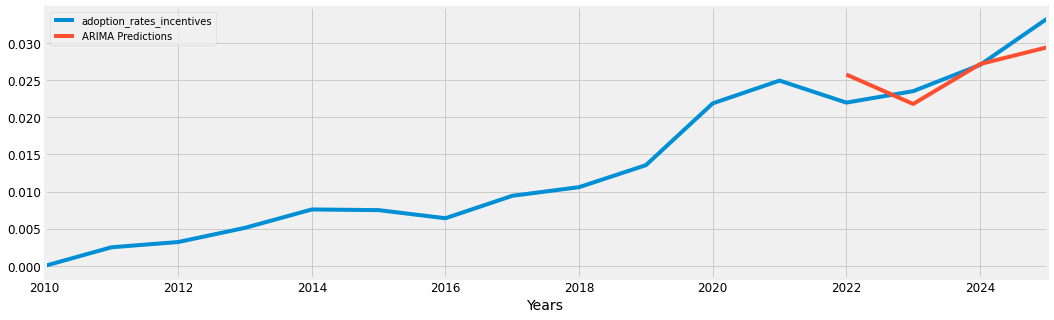

In [ ]:
# Plot on a line graph the adoption rates incentives and the predictions.
lstm_for_dfi['adoption_rates_incentives'].plot(figsize = (16,5), legend=True)
arima_predi.plot(legend = True);

In [ ]:
# Get the model evaluation metrics and print them.
arima_rmse_errori = rmse(test_datai['adoption_rates_incentives'], arima_predi)
arima_mse_errori = arima_rmse_errori**2
arima_mean_valuei = lstm_for_dfi['adoption_rates_incentives'].mean()
arima_r2_valuei = r2_score(test_datai['adoption_rates_incentives'],arima_predi)
arima_maei = mean_absolute_error(test_datai['adoption_rates_incentives'],arima_predi)

print(f'MSE Error: {arima_mse_errori}\nRMSE Error: {arima_rmse_errori}\nMean: {arima_mean_valuei}')
print("Mean absolute error: ", arima_maei)
print("R^2 Value: ", arima_r2_valuei)

MSE Error: 7.995021109432833e-06
RMSE Error: 0.0028275468359397395
Mean: 0.013662246083125001
Mean absolute error:  0.002363815965094858
R^2 Value:  0.5744979957219085


**Long-Short Term Memore Recurrent Neural Network**

In [ ]:
# Normalize the data with MinMaxScaler transformer.
scaleri = MinMaxScaler()
scaleri.fit(lstm_for_dfi)
scaled_lstm_dfi = scaleri.transform(lstm_for_dfi)


scaled_train_datai = scaleri.transform(train_datai)
scaled_test_datai = scaleri.transform(test_datai)

In [ ]:
"""
Declare the number of inputs and features passing through the neural nework and
define the train/test generator with the TimeSeriesGenerator.
"""
n_inputi = 11
n_featuresi= 1

train_generatori = TimeseriesGenerator(scaled_train_datai, scaled_train_datai, length=n_inputi, batch_size=1)
test_generatori = TimeseriesGenerator(scaled_test_datai, scaled_test_datai, length=3, batch_size=1)

In [ ]:
"""
Create the model with 200 neurons, activation relu, an input shape of a 2d 
tensor with the n_input and the n_features. Add an output layer of 1, and then
compile with adam optimization algorithm, mean square error as the loss function,
and mean absolute error as the metrics.

Display the model summary.
"""
backend.clear_session()
lstm_modeli = Sequential()
lstm_modeli.add(LSTM(200, activation='relu', input_shape=(n_inputi, n_featuresi)))
lstm_modeli.add(Dense(1))
lstm_modeli.compile(optimizer='adam', loss='mse',
             metrics = ['mae'])

lstm_modeli.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Define a history of the model by fitting the neural network with the train
generator and training on 25 epochs, using the test generator as validation.
"""
historyi = lstm_modeli.fit_generator(train_generatori,epochs=25, validation_data=test_generatori)

Epoch 1/25
1/1 [==============================] - 0s 209ms/step - loss: 0.5490 - mae: 0.7410 - val_loss: 0.9513 - val_mae: 0.9754
Epoch 2/25
1/1 [==============================] - 0s 48ms/step - loss: 0.5225 - mae: 0.7228 - val_loss: 0.9233 - val_mae: 0.9609
Epoch 3/25
1/1 [==============================] - 0s 43ms/step - loss: 0.4965 - mae: 0.7046 - val_loss: 0.8961 - val_mae: 0.9466
Epoch 4/25
1/1 [==============================] - 0s 43ms/step - loss: 0.4711 - mae: 0.6864 - val_loss: 0.8691 - val_mae: 0.9323
Epoch 5/25
1/1 [==============================] - 0s 50ms/step - loss: 0.4461 - mae: 0.6679 - val_loss: 0.8425 - val_mae: 0.9179
Epoch 6/25
1/1 [==============================] - 0s 44ms/step - loss: 0.4208 - mae: 0.6487 - val_loss: 0.8165 - val_mae: 0.9036
Epoch 7/25
1/1 [==============================] - 0s 43ms/step - loss: 0.3948 - mae: 0.6283 - val_loss: 0.7906 - val_mae: 0.8892
Epoch 8/25
1/1 [==============================] - 0s 45ms/step - loss: 0.3678 - mae: 0.6065 - va

In [ ]:
# Create a dictionary for the model history.
history_dicti = historyi.history
loss_valuesi = history_dicti['loss']
acc_valuesi = history_dicti['mae']
val_lossi = history_dicti['val_loss']
val_acci = history_dicti['val_mae']
epochsi = range(1, len(history_dicti['mae']) + 1)

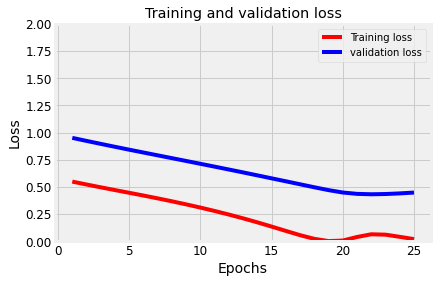

In [ ]:
# Plot the training and validation loss values against each other.
plt.plot(epochsi, loss_valuesi, 'r', label = 'Training loss')
plt.plot(epochsi, val_lossi, 'b', label = 'validation loss')
plt.ylim(0,2)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Get a list of the scaled predictions.
lstm_predictions_scaledi = list()

batchi = scaled_train_datai[-n_input:]
current_batchi = batchi.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_predi = lstm_modeli.predict(current_batchi)[0]
    lstm_predictions_scaledi.append(lstm_predi) 
    current_batchi = np.append(current_batchi[:,1:,:],[[lstm_predi]],axis=1)

In [ ]:
# Display the scaled predictions
lstm_predictions_scaledi

[array([0.94434047], dtype=float32),
 array([1.0799482], dtype=float32),
 array([1.2477168], dtype=float32),
 array([1.4496877], dtype=float32)]

In [ ]:
# Inverse transform the scaled predictions back to normal values.
lstm_predictionsi = scaleri.inverse_transform(lstm_predictions_scaledi)

In [ ]:
# Display the normal predictions.
lstm_predictionsi

array([[0.03139812],
       [0.0359069 ],
       [0.04148499],
       [0.04820027]])

In [ ]:
# Add the predictions to the dataframe.
test_datai['LSTM_Predictions'] = lstm_predictionsi

In [ ]:
# Display the predictions in the dataframe.
test_datai

,adoption_rates_incentives,LSTM_Predictions,Linear_Predictions,ARIMA_Predictions
Years,,,,
2022-01-01,0.021980,0.031398,0.026249,0.025755
2023-01-01,0.023518,0.035907,0.029428,0.021795
2024-01-01,0.027046,0.041485,0.033053,0.027163
2025-01-01,0.033249,0.048200,0.037461,0.029409


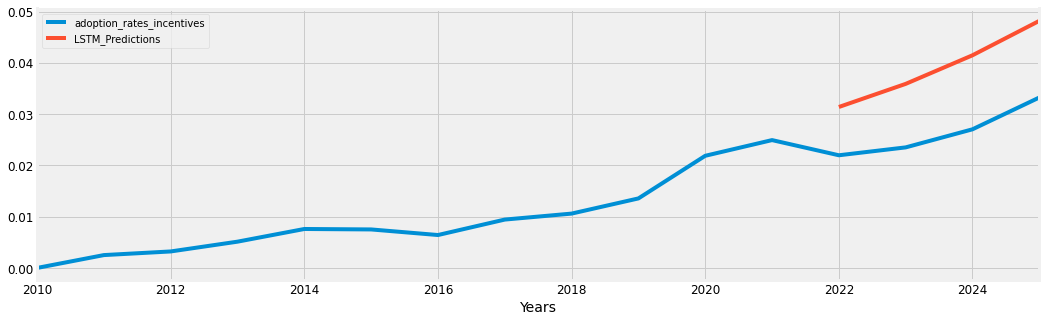

In [ ]:
# Plot the predictions with the adoption_rates_incentives on a line graph.
lstm_for_dfi['adoption_rates_incentives'].plot(figsize = (16,5), legend=True)
test_datai['LSTM_Predictions'].plot(legend = True);

In [ ]:
# Get the model evaluation metrics and print them.
lstm_rmse_errori = rmse(test_datai['adoption_rates_incentives'], test_datai["LSTM_Predictions"])
lstm_mse_errori = lstm_rmse_errori**2
lstm_mean_valuei = lstm_for_dfi['adoption_rates_incentives'].mean()
lstm_r2_valuei = r2_score(test_datai['adoption_rates_incentives'],test_datai["LSTM_Predictions"])
lstm_maei = mean_absolute_error(test_datai['adoption_rates_incentives'],test_datai["LSTM_Predictions"])

print(f'MSE Error: {lstm_mse_errori}\nRMSE Error: {lstm_rmse_errori}\nMean: {lstm_mean_valuei}')
print("Mean absolute error: ", lstm_maei)
print("R^2 Value: ", lstm_r2_valuei)

MSE Error: 0.00016855723752781803
RMSE Error: 0.012982959505745137
Mean: 0.013662246083125001
Mean absolute error:  0.012799509542060302
R^2 Value:  -7.970763356590169


In [ ]:
# Create a dataframe for all three model predictions starting with the LSTM.
df_resultsi = pd.DataFrame(test_datai)

In [ ]:
# Add the linear and ARIMA predictions to the dataframe.
df_resultsi['Linear_Predictions'] = df_lineari['Predicted'].values
df_resultsi['ARIMA_Predictions'] = arima_predi

In [ ]:
# Display the dataframe with all three predictions with the actual values.
df_resultsi

,adoption_rates_incentives,LSTM_Predictions,Linear_Predictions,ARIMA_Predictions
Years,,,,
2022-01-01,0.021980,0.031398,0.026249,0.025755
2023-01-01,0.023518,0.035907,0.029428,0.021795
2024-01-01,0.027046,0.041485,0.033053,0.027163
2025-01-01,0.033249,0.048200,0.037461,0.029409


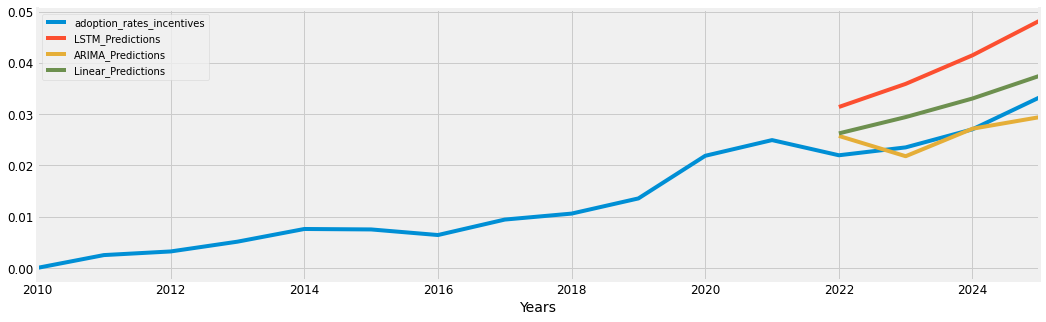

In [ ]:
# Plot on a line graph all three model predictions with the adoption_rates_incentives.
lstm_for_dfi['adoption_rates_incentives'].plot(figsize = (16,5), legend=True)
df_resultsi['LSTM_Predictions'].plot(legend = True)
df_resultsi['ARIMA_Predictions'].plot(legend = True)
df_resultsi['Linear_Predictions'].plot(legend = True);